In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-02-ESTADISTICA/master/init.py
import init; init.init(force_download=False); 
from IPython.display import Image

replicating local resources


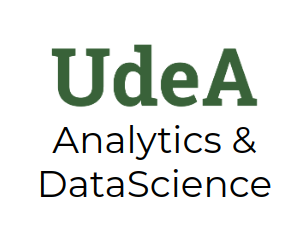

In [ ]:
Image("local/imgs/udea-datascience.png")

**Desarrollado por:** Javier Fernando Botía Valderrama

*Docente del Departamento de Ingeniería de Sistemas*

**Materia:** Estadística y Análisis Exploratorio

**Departamento:** Posgrado en Ingeniería

**Facultad de Ingeniería - Universidad de Antioquia**

# Métodos de Imputación de Datos y Escalamiento de Datos

In [ ]:
import pandas as pd
import io
import requests

from sklearn.impute import MissingIndicator # Es una función que permite identificar los datos faltantes
from sklearn.impute import SimpleImputer # Método de imputación 
from sklearn.impute import KNNImputer # Se utiliza la función KNNIMputer para aplicar la imputación KNN

from sklearn.preprocessing import StandardScaler # Escalamiento estándar
from sklearn.preprocessing import RobustScaler # Escalamiento robusto
from sklearn.preprocessing import MinMaxScaler # MinMaxScaler es una librería que permite 
                                               # hacer diferentes escalas de los datos cuando ajustes de valores máximos y mínimos.
from sklearn.preprocessing import Normalizer # Librería para normalizar datos en una escala deseada

import seaborn as sns # Librería de visualización para data science
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import scipy.stats

## Métodos de Imputación de Datos

La imputación de datos es un conjunto de métodos para evitar la eliminación de muestras u observaciones útiles y valiosos para analizar datos cuando hay presencia de **datos faltantes o datos nulos**. Por lo general, la imputación de datos utiliza técnicas de interpolación para estimar valores en los datos faltantes. Existen varias estrategías para imputar datos basados en *estadísticos o en algoritmos de vecinos más cercanos*. A continuación, vamos a revisar algunos de ellos:

*Descripción original de los datos*: 

This data set can be used to predict the severity (benign or malignant) of a mammographic mass lesion from BI-RADS attributes and the patient's age.

It contains a BI-RADS assessment, the patient's age and three BI-RADS attributes together with the ground truth (the severity field, which is the target attribute).

The data was collected at the Institute of Radiology of the University Erlangen-Nuremberg between 2003 and 2006.

https://sci2s.ugr.es/keel/dataset.php?cod=86

In [ ]:
url = "https://raw.githubusercontent.com/javierfernandobotia/AnalisisAvanzadoDatos/main/mammographic.dat"
download = requests.get(url).content
data = pd.read_table(io.StringIO(download.decode('utf-8')), sep=',',
                     decimal = ',')
# Esimportante codificarlo a utf-8
display(data.head(20))

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
5,4,65,1,?,3,0
6,4,70,?,?,3,0
7,5,42,1,?,3,0
8,5,57,1,5,3,1
9,5,60,?,5,1,1


### Estrategía de Diagnóstico de Datos Faltantes

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   961 non-null    object
 1   Age       961 non-null    object
 2   Shape     961 non-null    object
 3   Margin    961 non-null    object
 4   Density   961 non-null    object
 5   Severity  961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


**NOTA:** Es importante que el número de muestras de cada característica sea igual al número de muestras o filas de la base de datos original. Sin embargo, este tipo de exploración de datos no garantiza que exista datos faltantes o con caracteres extraños. Por esta razón, se recomienda hacer una exploración exhaustiva de la base de datos.

In [ ]:
BI_RADS = list(data['BI-RADS'].value_counts().index)
Age = list(data['Age'].value_counts().index)
Shape = list(data['Shape'].value_counts().index)
Margin = list(data['Margin'].value_counts().index)
Density  = list(data['Density'].value_counts().index)
Severity  = list(data['Severity'].value_counts().index)
display([[BI_RADS,Age,Shape,Margin,Density,Severity]])

[[['4', '5', '3', '2', '6', '0', '?'],
  ['59',
   '67',
   '57',
   '66',
   '46',
   '64',
   '55',
   '60',
   '54',
   '62',
   '65',
   '63',
   '53',
   '49',
   '58',
   '56',
   '71',
   '50',
   '45',
   '43',
   '52',
   '68',
   '42',
   '40',
   '44',
   '72',
   '76',
   '41',
   '51',
   '47',
   '35',
   '61',
   '70',
   '69',
   '74',
   '48',
   '80',
   '39',
   '36',
   '34',
   '77',
   '38',
   '73',
   '33',
   '37',
   '79',
   '31',
   '75',
   '23',
   '27',
   '32',
   '21',
   '83',
   '86',
   '28',
   '?',
   '87',
   '78',
   '85',
   '19',
   '24',
   '84',
   '29',
   '25',
   '30',
   '22',
   '26',
   '81',
   '88',
   '18',
   '82',
   '93',
   '96',
   '20'],
  ['4', '1', '2', '3', '?'],
  ['1', '4', '5', '3', '?', '2'],
  ['3', '?', '2', '1', '4'],
  [0, 1]]]

Como se sospechaba, hay datos faltantes "?" en varias características de nuestra base de datos. El siguiente paso, es convertir los datos "?" en datos "NaN" o nulos, con la finalidad de calcular un porcentaje total de datos faltantes de nuestra base de datos

In [ ]:
data = data.replace("?",np.nan) # Reemplazamos los datos ? por datos NaN o nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   959 non-null    object
 1   Age       956 non-null    object
 2   Shape     930 non-null    object
 3   Margin    913 non-null    object
 4   Density   885 non-null    object
 5   Severity  961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


Debido al análisis exploratorio exhaustivo, se descubrió que en realidad hay datos faltantes en nuestra base de datos. Vamos a calcular un porcentaje de los datos faltantes de nuestra base de datos.

In [ ]:
Indicador = MissingIndicator(missing_values = np.nan) # Decimos que datos debe buscar como datos faltantes
Indicador.fit(data) # Aplicamos el método de búsqueda con nuestra base de datos
Datos_Indicador = Indicador.transform(data) # Realizamos una transformación Booleana de los datos para identificar los datos faltantes (True)
                                             # y los datos no faltantes (False)
display(Datos_Indicador) # Mostramos los resultados de la búsqueda de los datos faltantes y no faltantes

array([[False, False, False, False, False],
       [False, False, False, False,  True],
       [False, False, False, False, False],
       ...,
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [ ]:
print("Características donde hay datos faltantes: ", Indicador.features_)

Características donde hay datos faltantes:  [0 1 2 3 4]


In [ ]:
POS = np.where(Datos_Indicador == True) # Se busca aquellos datos que tiene un valor Booleanos igual a True
print("Porcentaje de Datos Faltantes (%): ", 100*(len(POS[0])/(Datos_Indicador.shape[0]*Datos_Indicador.shape[1])))

Porcentaje de Datos Faltantes (%):  3.3714880332986477


Lo anterior indica que hay 3.37 % de datos faltantes. Ahora viene la siguiente pregunta: ¿Cómo rellenar los datos faltantes?. La principal estrategía es la **Imputación de datos**

### Imputación Simple

#### Imputación de la media

Es un método que sustituye los valores faltantes por el valor promedio de cada característica de los datos. A continuación, se muestra un ejemplo práctico:

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy= 'mean') # Rellena los datos NaN por medio del cálculo de la media
imp.fit(data) # Aplicamos el método con los datos
Datos_Imputacion_Media = imp.transform(data) # Realizamos la imputación de la media con nuestros datos
nombres = data.columns # Extraer los nombres de las columnas
Datos_Imputacion_Media = pd.DataFrame(Datos_Imputacion_Media, columns = nombres)
display(Datos_Imputacion_Media)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.000000,1.0
1,4.0,43.0,1.0,1.0,2.910734,1.0
2,5.0,58.0,4.0,5.0,3.000000,1.0
3,4.0,28.0,1.0,1.0,3.000000,0.0
4,5.0,74.0,1.0,5.0,2.910734,1.0
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.000000,0.0
957,4.0,56.0,4.0,5.0,3.000000,1.0
958,4.0,64.0,4.0,5.0,3.000000,0.0
959,5.0,66.0,4.0,5.0,3.000000,1.0


In [ ]:
Datos_Imputacion_Media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


Como se puede observar, se logró rellenar los datos faltantes y el tipo de dato ahora es Float 64 bits, logrando reducir un poco el uso de memoría para almacenar los datos.

#### Imputación de la mediana

Es un método que sustituye los valores faltantes por el valor de la mediana de cada característica de los datos. A continuación, se muestra un ejemplo práctico:

In [ ]:
imp_2 = SimpleImputer(missing_values = np.nan, strategy= 'median') # Rellena los datos NaN por medio del cálculo de la mediana
imp_2.fit(data)
Datos_Imputacion_Mediana = imp_2.transform(data)
nombres = data.columns
Datos_Imputacion_Mediana = pd.DataFrame(Datos_Imputacion_Mediana, columns = nombres)
display(Datos_Imputacion_Mediana)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1.0
1,4.0,43.0,1.0,1.0,3.0,1.0
2,5.0,58.0,4.0,5.0,3.0,1.0
3,4.0,28.0,1.0,1.0,3.0,0.0
4,5.0,74.0,1.0,5.0,3.0,1.0
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0.0
957,4.0,56.0,4.0,5.0,3.0,1.0
958,4.0,64.0,4.0,5.0,3.0,0.0
959,5.0,66.0,4.0,5.0,3.0,1.0


In [ ]:
Datos_Imputacion_Mediana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


#### Imputación con los datos más frecuentes

Es un método que reemplaza los valores faltantes por los valores más frecuentes de cada características de los datos. A continuación, se muestra un ejemplo práctico:

In [ ]:
imp_3 = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent') # Rellena los datos NaN por medio del cálculo de los valores más frecuentes
imp_3.fit(data)
Datos_Imputacion_Frecuente = imp_3.transform(data)
nombres = data.columns
Datos_Imputacion_Frecuente = pd.DataFrame(Datos_Imputacion_Frecuente, columns = nombres)
display(Datos_Imputacion_Frecuente)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,3,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


In [ ]:
Datos_Imputacion_Frecuente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   961 non-null    object
 1   Age       961 non-null    object
 2   Shape     961 non-null    object
 3   Margin    961 non-null    object
 4   Density   961 non-null    object
 5   Severity  961 non-null    object
dtypes: object(6)
memory usage: 45.2+ KB


Como pueden observar, este método genera que cada característica de los datos sea tipo **object** pero es mejor convertirlo a datos enteros o datos tipo flotante para manipular mejor los datos.

In [ ]:
for i in range(0, len(Datos_Imputacion_Frecuente.columns)):
    Datos_Imputacion_Frecuente.iloc[:,i] = pd.to_numeric(Datos_Imputacion_Frecuente.iloc[:,i], 
                                                         errors='ignore', downcast = 'float')
Datos_Imputacion_Frecuente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float32
 1   Age       961 non-null    float32
 2   Shape     961 non-null    float32
 3   Margin    961 non-null    float32
 4   Density   961 non-null    float32
 5   Severity  961 non-null    float32
dtypes: float32(6)
memory usage: 22.6 KB


Observen que esta estretegia reduce aún más el uso de memoría - Una pequeña Ñapa de la experiencia :) 

### Imputación con el Algoritmo de los Vecinos más Cercanos

Es un método de imputación basado en el algoritmo de los vecinos más cercanos o KNN. Este método rellena los valores faltantes por medio de un cálculo de la distancia euclidiana de los vecinos más cercanos y a cada característica, se imputa los valores faltantes a través de un promedio uniforme. Sin embargo, si a cada característica le falta más de un valor, los vecinos para esa muestra pueden ser diferentes dependiendo de la característica particular que se imputa. Es importante tener en cuenta que si el número de vecinos que define el usuario es menor al número de vecinos que se puede determinar en los datos, y además que no hay distancias euclidianas que se puedan calcular, la imputación se realiza por un promedio de los valores existentes (como en la imputación por la media). En caso que hay al menos un vecino con distancia calculada, se aplica un promedio ponderado o no ponderado con los vecinos restantes.

In [ ]:
imp_4 = KNNImputer(missing_values = np.nan, n_neighbors = 5, weights= "uniform") # pdf uniforme P = Na/N 
# Imputación por el algoritmo KNN con 5 vecinos y promedio uniforme.
imp_4.fit(data)
Datos_Imputacion_KNN_1 = imp_4.transform(data)

In [ ]:
imp_5 = KNNImputer(missing_values = np.nan, n_neighbors = 5, weights= "distance") # distancia Euclidiana
# Imputación por el algoritmo KNN con 5 vecinos y promedio ponderado donde 
# los vecinos más cercanos de un valor tendrán una mayor influencia que los vecinos que están más lejos.
imp_5.fit(data)
Datos_Imputacion_KNN_2 = imp_5.transform(data)

In [ ]:
Datos_Imputacion_KNN_1 = pd.DataFrame(Datos_Imputacion_KNN_1, columns = nombres)
Datos_Imputacion_KNN_2 = pd.DataFrame(Datos_Imputacion_KNN_2, columns = nombres)

In [ ]:
Datos_Imputacion_KNN_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


In [ ]:
Datos_Imputacion_KNN_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   961 non-null    float64
 1   Age       961 non-null    float64
 2   Shape     961 non-null    float64
 3   Margin    961 non-null    float64
 4   Density   961 non-null    float64
 5   Severity  961 non-null    float64
dtypes: float64(6)
memory usage: 45.2 KB


**Nota:** Se sugiere usar un número de vecinos más cercanos en valores impares, es decir, $\lbrace 3, 5, 7, 9, 11, 13, \ldots \rbrace$. Sugiero hacer una lectura del siguiente Blog que explica en detalle esta recomendación: \url{https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/}

Hasta este punto, tenemos cuatro estrategías para imputar datos, pero, ¿Cúal seleccionamos para seguir con nuestra exploración de datos?. Si analizamos los datos, todos los datos son enteros positivos, por consiguiente, la imputación de la media no se seleccionaría porque genere datos rellenados con valores reales o con decimales en el lenguaje común. Por consiguiente, se seleccionará los datos con imputación a la mediana porque los datos son enteros positivos, aunque los otros métodos como los datos más frecuentes o KNN genera valores enteros positivos. El criterio de selección depende del analizador de datos.

## Escalamiento de Datos

Por lo general, el escalamiento de datos es un conjunto de transformaciones de los datos tal que reduce la sensibilidad de la escala de entrada de los modelos de machine learning. Inicialmente, vamos a analizar dos transformaciones matemáticas: **escalamiento estándar** y **escalamiento robusto**. Más adelante, se explicará un caso especial del escalamiento de datos llamado **normalización de datos**, donde vamos a conocer cuatro transformaciones para normalizar. Lo anterior permite establecer que la normalización es un *caso especial* del escalamiento de datos.

In [ ]:
url = "https://raw.githubusercontent.com/javierfernandobotia/AnalisisAvanzadoDatos/main/phoneme.dat"
download = requests.get(url).content
data = pd.read_table(io.StringIO(download.decode('utf-8')), sep=',',
                     decimal = ',')
# Esimportante codificarlo a utf-8
display(data.head(20))

,Aa,Ao,Dcl,Iy,Sh,Class
0,1.24,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.3,1.041,0.559,0
3,0.279,0.99,2.555,-0.738,0.0,0
4,0.307,1.272,2.656,-0.946,-0.467,0
5,0.96,0.712,-0.143,0.091,-0.061,0
6,2.941,0.657,1.493,-0.331,-0.123,0
7,0.401,1.159,2.064,-0.69,-0.308,0
8,0.229,1.748,0.634,0.259,0.0,0
9,0.303,0.609,0.474,1.427,-0.811,1


### Escalamiento Estándar

Es una transformación donde los datos son restados por la media de cada característica y dividido por la varianza de cada característica.

$$\hat{x}_{n,d} = \frac{x_{n,d} - m_{d}}{\sigma_d}$$

donde:

*   $\hat{x}_{n,d}$ es una muestra escalada de una muestra $n$ con respecto a una característica $d$.
*   $x_{n,d}$ es una muestra no escalada de una muestra $n$ con respecto a una característica $d$.
*   $m_{d}$ es la media de una característica $d$.
*   $\sigma_d$ es la varianza de una característica $d$.

Si la media es 0 y la varianza es 1, los datos originales tendrán una *distribución Gaussiana*. Veamos una ejemplo aplicativo del escalamiento estándar

In [ ]:
data = data[['Aa',	' Ao',	' Dcl',	' Iy',	' Sh']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Aa      5404 non-null   object
 1    Ao     5404 non-null   object
 2    Dcl    5404 non-null   object
 3    Iy     5404 non-null   object
 4    Sh     5404 non-null   object
dtypes: object(5)
memory usage: 211.2+ KB


In [ ]:
data = data.astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Aa      5404 non-null   float64
 1    Ao     5404 non-null   float64
 2    Dcl    5404 non-null   float64
 3    Iy     5404 non-null   float64
 4    Sh     5404 non-null   float64
dtypes: float64(5)
memory usage: 211.2 KB


In [ ]:
data.describe()

,Aa,Ao,Dcl,Iy,Sh
count,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000
mean,0.818957,1.258802,0.764732,0.398743,0.078619
std,0.858733,0.851057,0.925436,0.796531,0.575624
min,-1.700000,-1.327000,-1.823000,-1.581000,-1.284000
25%,0.243750,0.596000,-0.115000,-0.205000,-0.232250
50%,0.492500,1.075500,0.729000,0.285500,-0.044000
75%,1.089250,1.866250,1.484000,0.937000,0.196250
max,4.107000,4.378000,3.199000,2.826000,2.719000


In [ ]:
SS = StandardScaler()
data_SS = SS.fit_transform(data) # Se realiza la transformación del conjunto de datos. Para este caso, utilizaremos los datos imputados por la media de los ejemplos anteriores.
print(data_SS)  # Resultado del escalamiento estándar

[[ 0.49035227 -0.45101251 -1.04796119 -0.59857896 -0.02018657]
 [-0.64165252  0.10951862  0.29207121 -0.91749121  0.24042422]
 [ 0.87118105 -0.46041345  0.57844911  0.80639274  0.83461682]
 ...
 [ 0.24694795 -0.79297175  1.19010906  1.42287272 -1.30239164]
 [-0.77907698 -0.38285569  1.72720269 -1.43227084 -1.20857176]
 [-0.79421696 -0.64020646  0.63248267  0.71975909 -1.23115802]]


In [ ]:
data_SS = pd.DataFrame(data_SS, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])
display(data_SS)

,Aa,Ao,Dcl,Iy,Sh
0,0.490352,-0.451013,-1.047961,-0.598579,-0.020187
1,-0.641653,0.109519,0.292071,-0.917491,0.240424
2,0.871181,-0.460413,0.578449,0.806393,0.834617
3,-0.628842,-0.315874,1.934692,-1.427249,-0.136593
4,-0.596233,0.015509,2.043839,-1.688405,-0.947961
...,...,...,...,...,...
5399,-0.657957,1.331641,-0.081841,1.794518,-1.081741
5400,-0.044206,-0.010343,0.030549,-0.019766,1.281130
5401,0.246948,-0.792972,1.190109,1.422873,-1.302392
5402,-0.779077,-0.382856,1.727203,-1.432271,-1.208572


In [ ]:
data_SS.describe()

,Aa,Ao,Dcl,Iy,Sh
count,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03,5.404000e+03
mean,1.275401e-16,3.158917e-16,2.826919e-17,1.840784e-17,2.498207e-17
std,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00
min,-2.933613e+00,-3.038622e+00,-2.796487e+00,-2.485686e+00,-2.367421e+00
25%,-6.698944e-01,-7.788703e-01,-9.507008e-01,-7.580351e-01,-5.401051e-01
50%,-3.801967e-01,-2.154014e-01,-3.861420e-02,-1.421829e-01,-2.130385e-01
75%,3.147867e-01,7.138229e-01,7.772926e-01,6.758145e-01,2.043731e-01
max,3.829301e+00,3.665425e+00,2.630644e+00,3.047567e+00,4.587412e+00


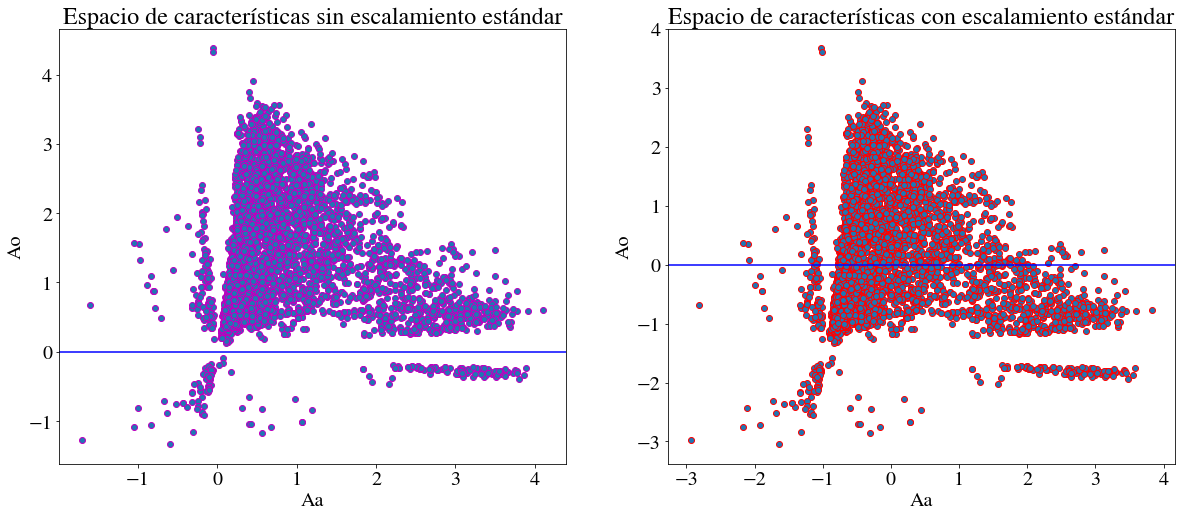

In [ ]:
fig = plt.figure(figsize=(20,8)) # Se define el tamaño de la figura en ancho y altura    

matplotlib.rcParams.update({'font.size': 20, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

ax = fig.add_subplot(1, 2, 1)   
ax.scatter(data['Aa'], data[' Ao'], edgecolors="m")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Espacio de características sin escalamiento estándar') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(1, 2, 2) 
ax.scatter(data_SS['Aa'], data_SS[' Ao'], edgecolors="r")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Espacio de características con escalamiento estándar') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

plt.show()

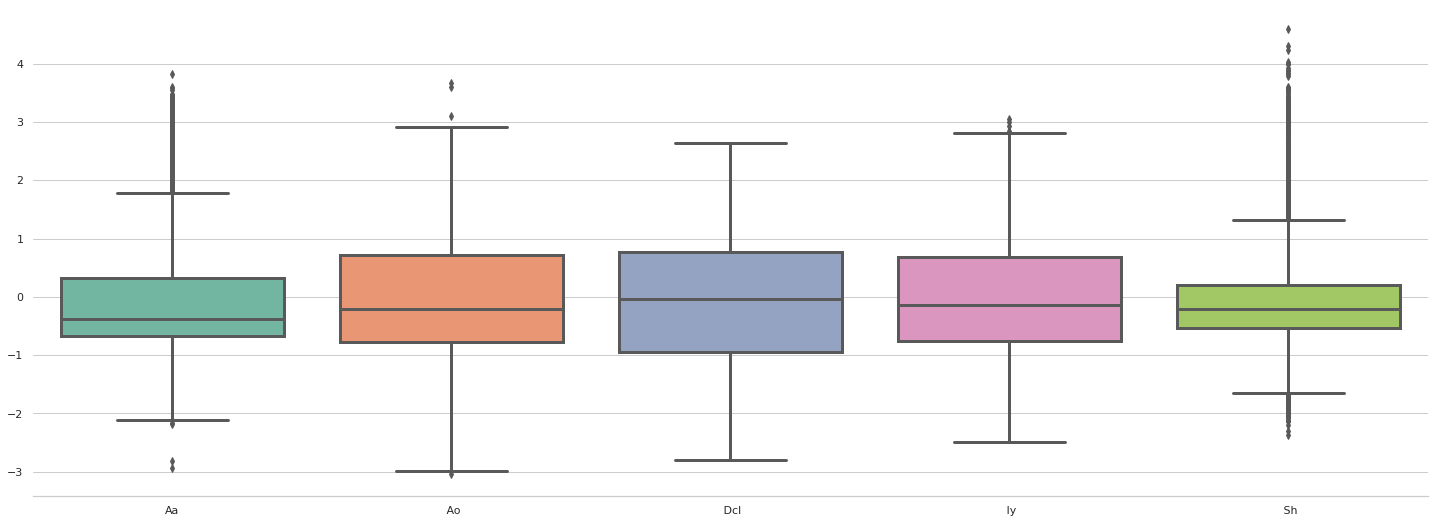

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_SS, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con escalamiento estándar
sns.despine(left=True)

### Escalamiento Robusto

Es una transformación de datos cuando hay presencia de datos atípicos u outliers. Por lo general, esta transformación escala los datos en un **rango de cuartiles**, permitiendo escalar los datos independientemente para cada características al computar las estadísticas más importantes de las muestras de los datos, como la media y la desviación estándar. Esta transformación utiliza un método llamado **rango intercuartiles**, que maneja desde el primer cuartil hasta el tercer cuartil.

Veamos un ejemplo práctico de esta transformación de datos:

In [ ]:
RS_1 = RobustScaler(quantile_range = (15, 75)) # (Primer cuartil, tercer cuartil)
RS_2 = RobustScaler(quantile_range = (20, 65))
RS_3 = RobustScaler(quantile_range = (30, 60))

data_RS_1 = RS_1.fit_transform(data)
data_RS_2 = RS_2.fit_transform(data)
data_RS_3 = RS_3.fit_transform(data)

data_RS_1 = pd.DataFrame(data = data_RS_1, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])
data_RS_2 = pd.DataFrame(data = data_RS_2, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])
data_RS_3 = pd.DataFrame(data = data_RS_3, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])

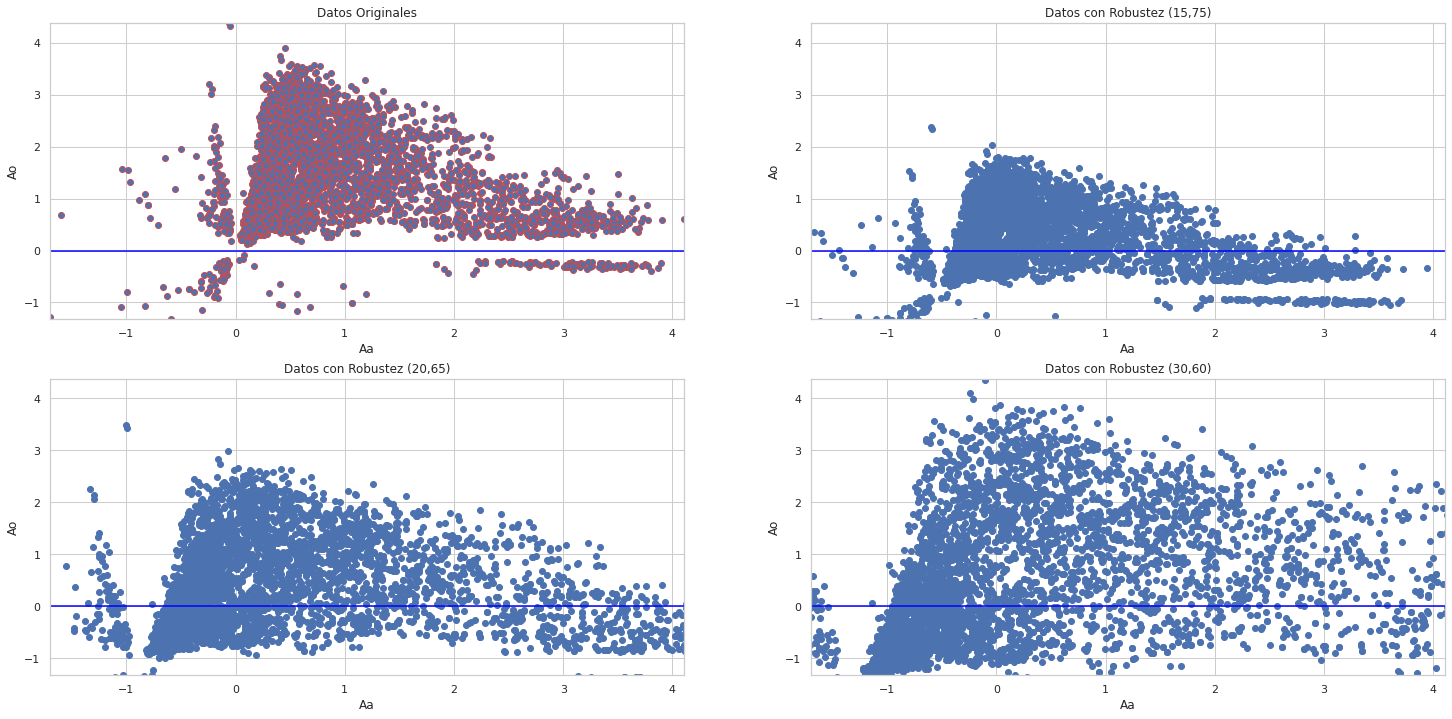

In [ ]:
fig = plt.figure(figsize=(25,12))

ax = fig.add_subplot(2, 2, 1)   
ax.scatter(data['Aa'], data[' Ao'], edgecolors="r")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.xlim(data['Aa'].min(),data['Aa'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje x
plt.ylim(data[' Ao'].min(),data[' Ao'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje y
plt.title('Datos Originales') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(2, 2, 2) 
ax.scatter(data_RS_1['Aa'], data_RS_1[' Ao'], edgecolors="b")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.xlim(data['Aa'].min(),data['Aa'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje x
plt.ylim(data[' Ao'].min(),data[' Ao'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje y
plt.title('Datos con Robustez (15,75)') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(2, 2, 3) 
ax.scatter(data_RS_2['Aa'], data_RS_2[' Ao'], edgecolors="b")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.xlim(data['Aa'].min(),data['Aa'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje x
plt.ylim(data[' Ao'].min(),data[' Ao'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje y
plt.title('Datos con Robustez (20,65)') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(2, 2, 4) 
ax.scatter(data_RS_3['Aa'], data_RS_3[' Ao'], edgecolors="b")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.xlim(data['Aa'].min(),data['Aa'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje x
plt.ylim(data[' Ao'].min(),data[' Ao'].max()) # Definir el rango de valores que desea que aparezca en el gráfico en el eje y
plt.title('Datos con Robustez (30,60)') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

plt.show()

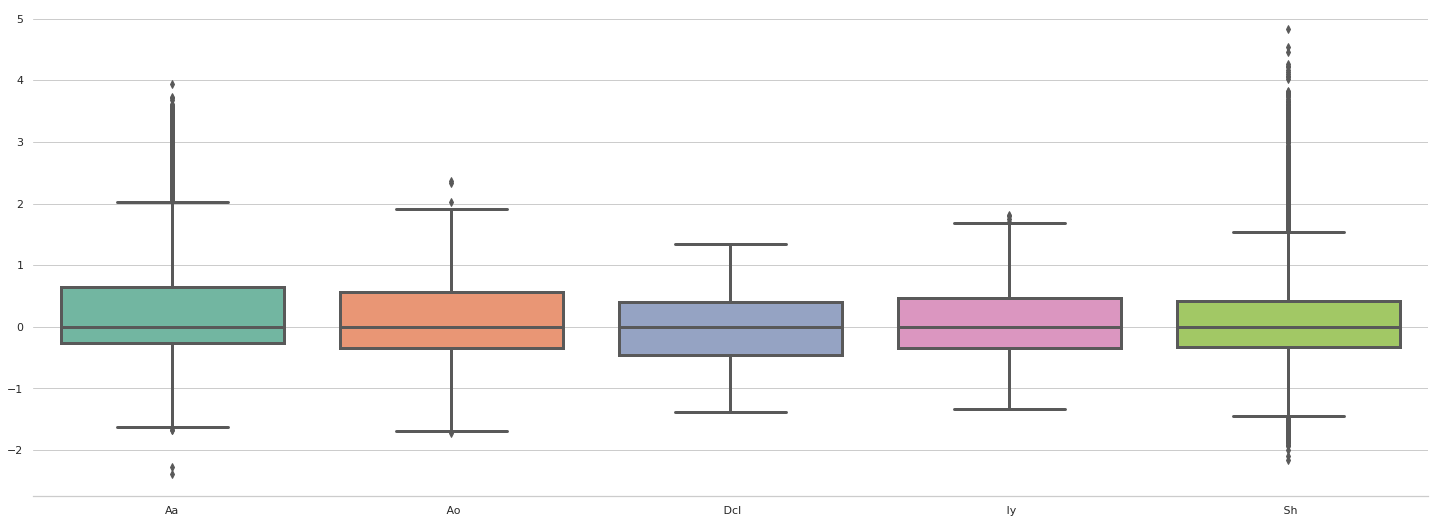

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_RS_1, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con escalamiento robusto (15, 75)
sns.despine(left=True)

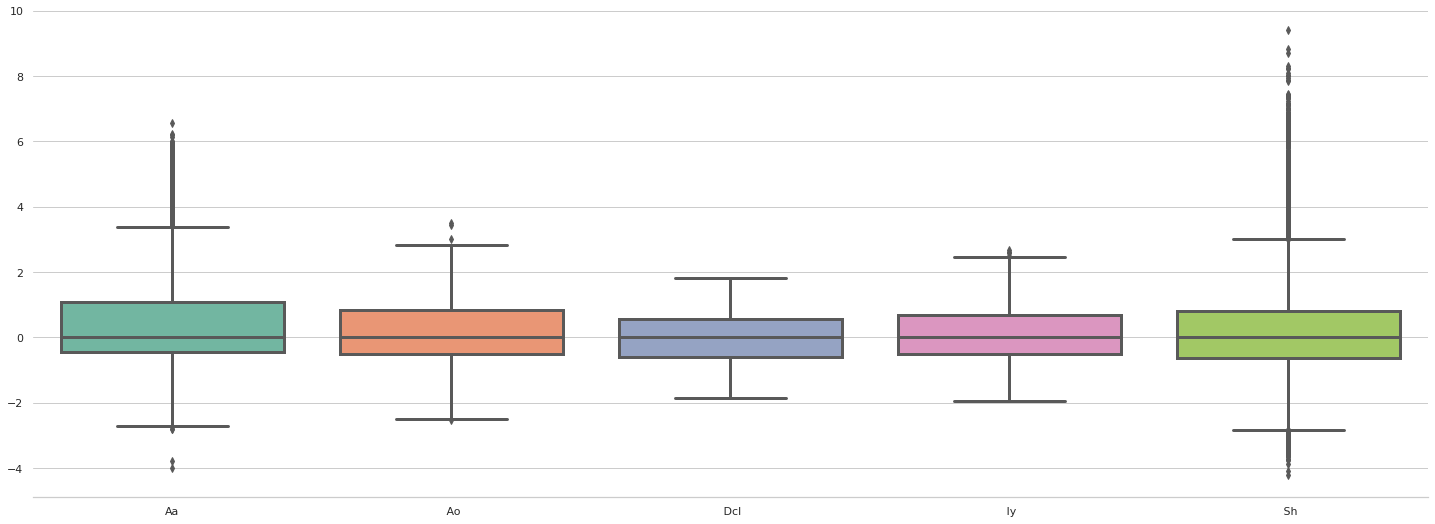

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_RS_2, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con escalamiento robusto (15, 75)
sns.despine(left=True)

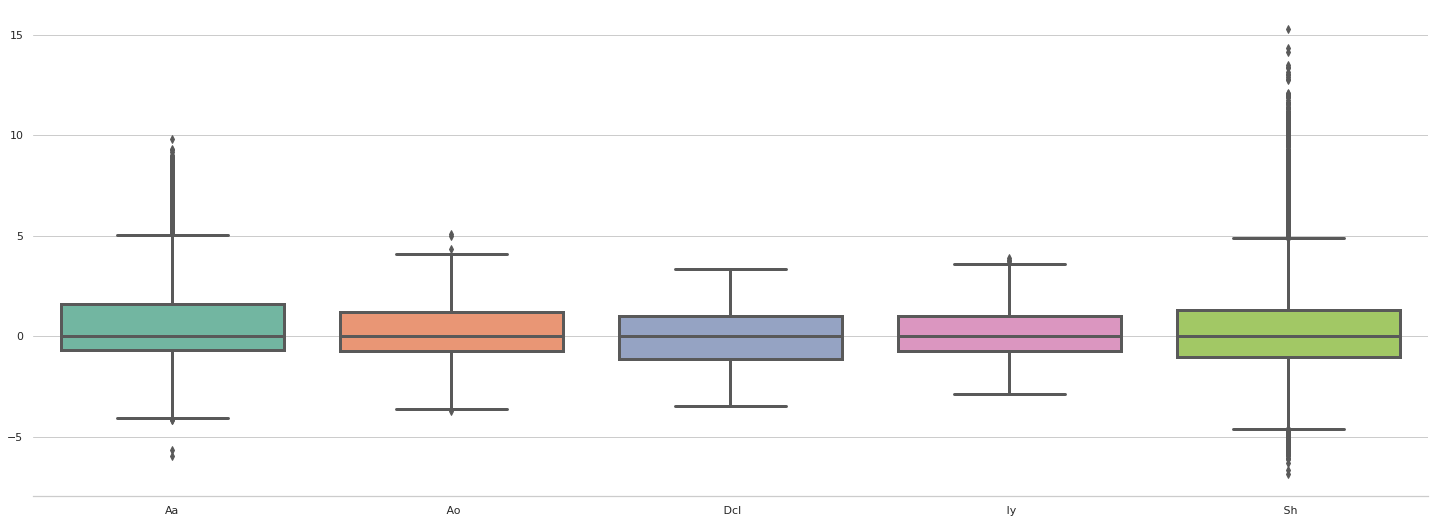

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_RS_3, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con escalamiento robusto (15, 75)
sns.despine(left=True)

## Normalización

La **Normalización** se define como una transformación de los datos en una escala entre 0 y 1 (datos normales) o entre un rango menor, es decir, $0 < \hat{x} < 1$. Veamos algunas de estas transformaciones:

#### Normalización Min-Max

Esta transformación llamada escalamiento min-max, normaliza los datos a una escala en el rango $\lbrack 0,1 \rbrack$, estrechando todos los datos.

*Definición formal de Min-Max:* Dado $x_{n,d}$ un dato de una muestra $n$ con respecto a una características $d$, decimos que $\hat{x}_{n,d}$ es un dato normalizado, tal que  $0 \leq \hat{x}_{n,d} \leq 1$, donde la normalización es la razón entre la resta $x_{n,d} - xmin_{d}$ y la resta entre $xmax_d - xmin_{d}$, siendo $xmin_{d}$ y $xmax_{d}$ el valor mínimo y máximo de cada característica $d$, respectivamente.

$$\hat{x}_{n,d} = \frac{x_{n,d} - xmin_{d}}{xmax_{d} - xmin_{d}}$$

Veamos un ejemplo de aplicación de esta transformación:

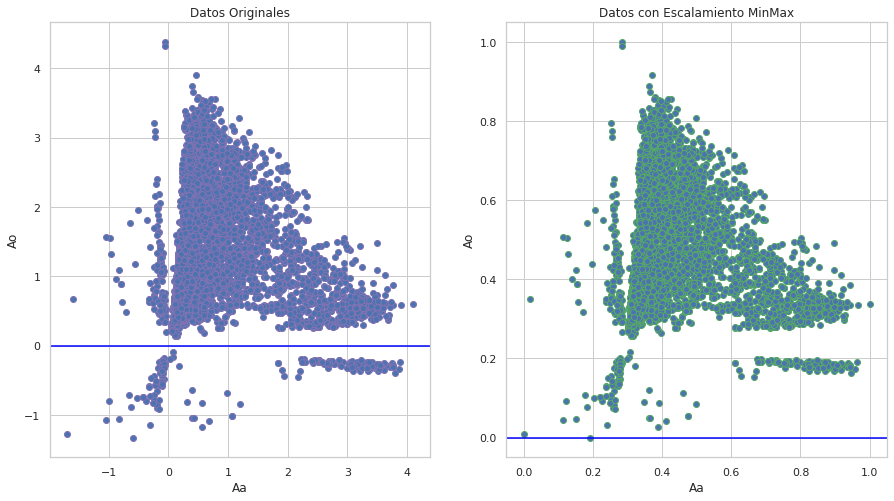

In [ ]:
MinMax_1 = MinMaxScaler(copy=True, feature_range=(0, 1)) # Método MinMax con valores entre 0 y 1
data_Min_Max = MinMax_1.fit_transform(data) # Transformación de los nuevos datos con una escala MinMax
data_Min_Max = pd.DataFrame(data = data_Min_Max, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])

fig = plt.figure(figsize=(15,8)) # Se define el tamaño de la figura en ancho y altura    
    
ax = fig.add_subplot(1, 2, 1)   
ax.scatter(data['Aa'], data[' Ao'], edgecolors="m")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Datos Originales') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(1, 2, 2) 
ax.scatter(data_Min_Max['Aa'], data_Min_Max[' Ao'],edgecolors="g")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Datos con Escalamiento MinMax') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

plt.show()

In [ ]:
data_Min_Max.describe()

,Aa,Ao,Dcl,Iy,Sh
count,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000
mean,0.433779,0.453252,0.515279,0.449227,0.340399
std,0.147879,0.149177,0.184276,0.180742,0.143798
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.334725,0.337073,0.340104,0.312231,0.262740
50%,0.377562,0.421122,0.508164,0.423531,0.309768
75%,0.480325,0.559728,0.658503,0.571364,0.369785
max,1.000000,1.000000,1.000000,1.000000,1.000000


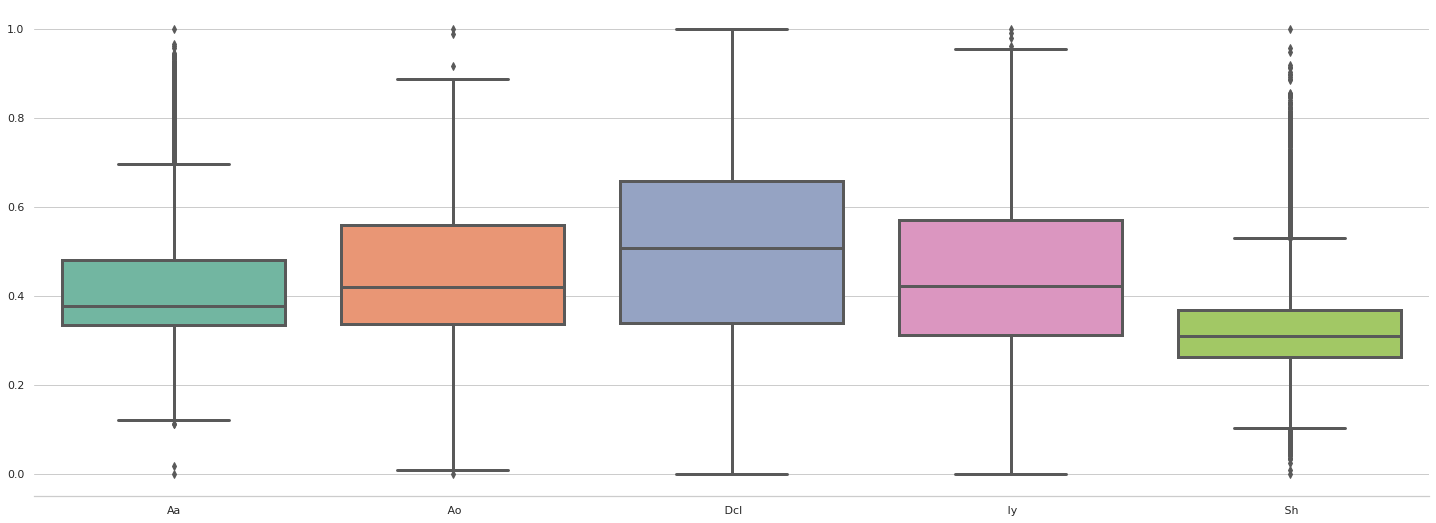

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_Min_Max, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con normalización Min-Max
sns.despine(left=True)

### Máxima Normalización

Es una transformación de datos que relaciona los datos $x_{n,d}$ con respecto al máximo valor de los datos por cada característica $d$, $xmax_{d}$:

$$\hat{x}_{n,d} = \frac{x_{n,d}}{xmax_{d}}$$

NOTA: Si los máximos valores de los datos originales son 1, no hay necesidad de utilizar este método de normalización.

Veamos un ejemplo de aplicación:

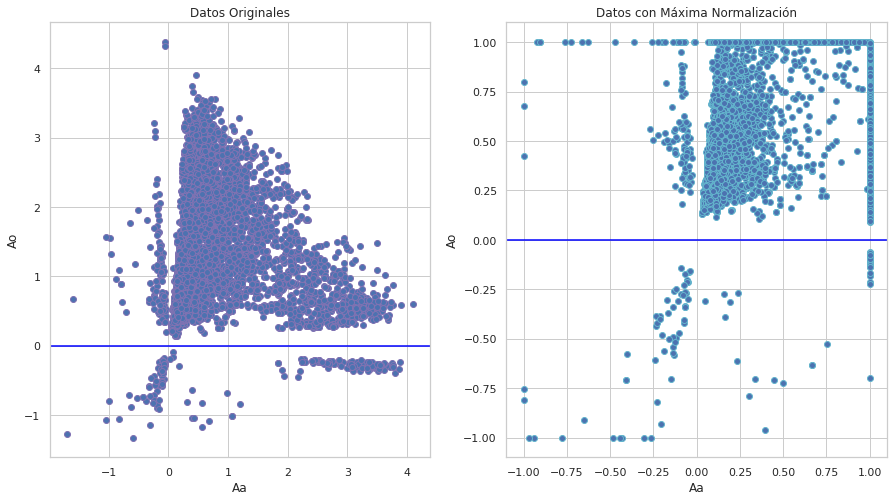

In [ ]:
NM = Normalizer(norm ='max') # Método de maxima normalización
data_NM = NM.fit_transform(data)
data_NM = pd.DataFrame(data = data_NM, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])

fig = plt.figure(figsize=(15,8)) # Se define el tamaño de la figura en ancho y altura    
    
ax = fig.add_subplot(1, 2, 1)   
ax.scatter(data['Aa'], data[' Ao'], edgecolors="m")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Datos Originales') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(1, 2, 2) 
ax.scatter(data_NM['Aa'], data_NM[' Ao'], edgecolors="c")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Datos con Máxima Normalización') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

plt.show()

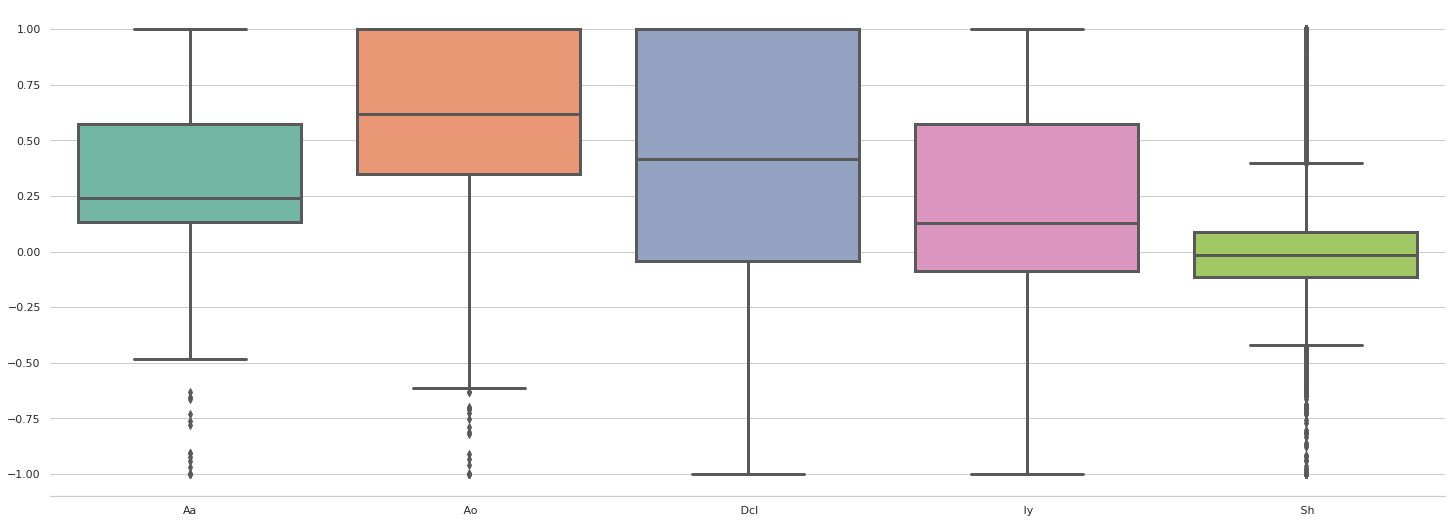

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_NM, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con normalización máxima
sns.despine(left=True)

### Normalización L1 - L2

Es una transformación de datos que relaciona los datos $x_{n,d}$ con respecto a una norma L1 o una norma L2 o Euclidiana:

$$L1(x_{n,d}) = \frac{x_{n,d}}{\vert \vert x \vert \vert_{1}} =\frac{x_{n,d}}{\sum_{n=1}^N \vert x_{n,d}\vert}$$

$$L2(x_{n,d}) = \frac{x_{n,d}}{\vert \vert x \vert \vert_{2}}= \frac{x_{n,d}}{\sqrt{\sum_{n=1}^N \vert x_{n,d}\vert^2}}$$

En la norma L2, los datos son divididos o medidos por la longitud del vector en el espacio de coordenadas, lo cual no cambia la forma de la distribución natural de los datos originales debido a que esta normalización siempre se divide por una constante L2, $\vert \vert x \vert \vert_{2}$.

Veamos un ejemplo aplicativo de esta transformación:

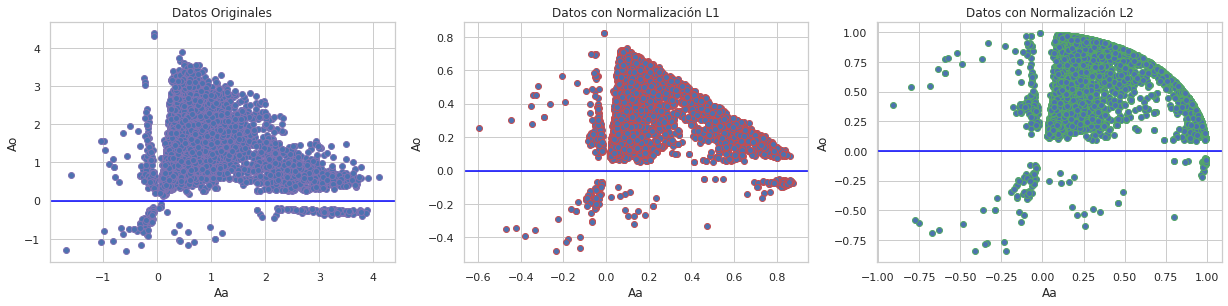

In [ ]:
L1 = Normalizer(norm ='l1') # Método de normalización L1
L2 = Normalizer(norm ='l2') # Método de normalización L2

data_L1 = L1.fit_transform(data)
data_L2 = L2.fit_transform(data)
data_L1 = pd.DataFrame(data = data_L1, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])
data_L2 = pd.DataFrame(data = data_L2, columns = ['Aa',	' Ao',	' Dcl',	' Iy',	' Sh'])

fig = plt.figure(figsize=(21,15)) # Se define el tamaño de la figura en ancho y altura    
    
ax = fig.add_subplot(3, 3, 1)   
ax.scatter(data['Aa'], data[' Ao'], edgecolors="m")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Datos Originales') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(3, 3, 2) 
ax.scatter(data_L1['Aa'], data_L1[' Ao'], edgecolors="r")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Datos con Normalización L1') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

ax = fig.add_subplot(3, 3, 3) 
ax.scatter(data_L2['Aa'], data_L2[' Ao'], edgecolors="g")
plt.axhline(0, color="blue") # Elegir color de la linea horizontal de referencia
plt.title('Datos con Normalización L2') # Titulo de la gráfica
plt.xlabel('Aa') # Etiqueta del eje x
plt.ylabel('Ao') # Etiqueta del eje y

plt.show()

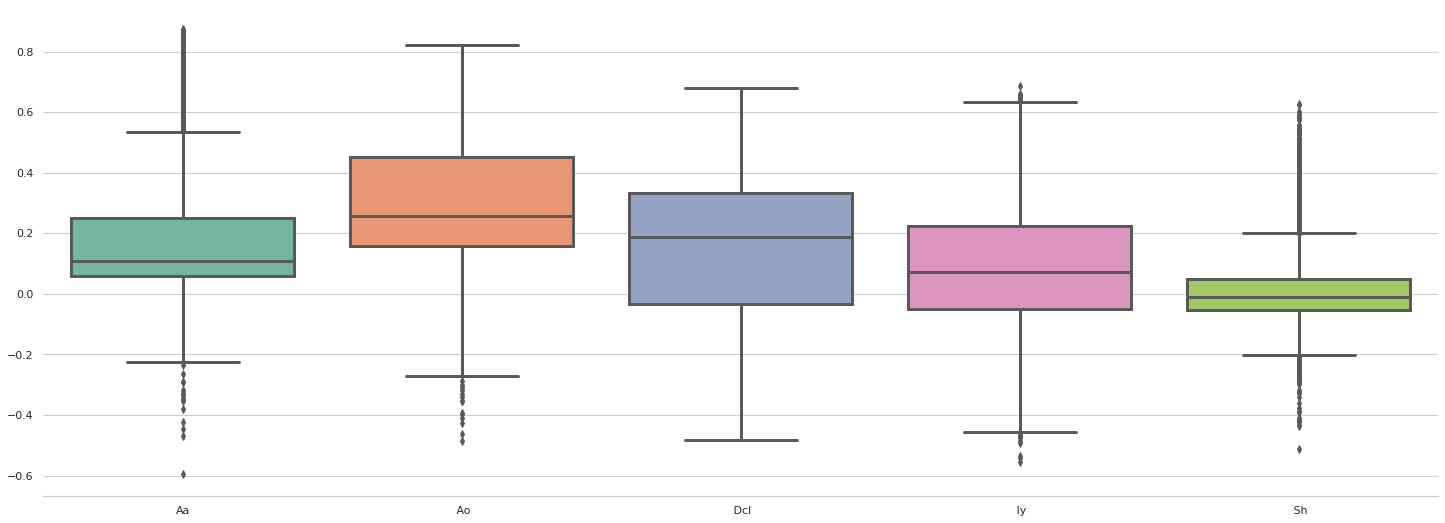

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_L1, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con normalización L1
sns.despine(left=True)

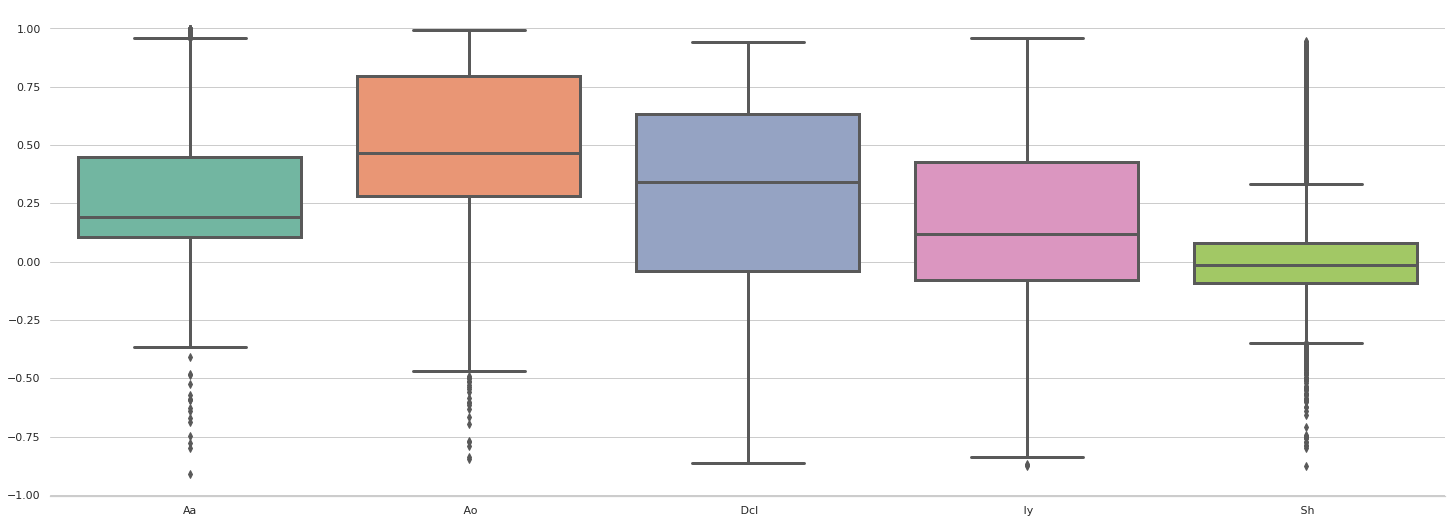

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data_L2, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot con los datos con normalización L1
sns.despine(left=True)

## Recomendaciones para el escalamiento de datos

1.   Cuando hay datos muy esparcidos (observándolos en el espacio de características), la normalización min-max y el escalamiento estándar pueden substraer una cantidad de datos desde los datos originales. Para este caso, la normalización min-max genera un desplazamiento sobre los valores mínimos de todas las características de los datos originales. Para el caso del escalamiento estándar, el desplazamiento se genera sobre los valores promedio de todas las características de los datos originales. Lo anterior puede ocasionar una alteración de los datos con valores mínimos o promedio si los datos tienen demasiado esparcidos en el espacio de características.

2.   Considerando el mismo caso de los datos esparcidos, si el desplazamiento no es cero, entonces ambas transformaciones pueden convertir un vector de características dispersa donde la mayoría de los valores son cero cuando los datos están demasiado esparcidos. Lo anterior puede ocasionar un incremento el costo de máquina (consumo de memoría RAM) cuando se construye modelos con algoritmos de machine learning.